In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
omega = 2. * np.pi / (5.4 * 60.) # s^-1 ; ang freq for 5.4 minute oscillation
gamma = 1. / (2 * 24. * 60. * 60.) # s^-1 ; 2-day damping timescale
dt = 50. # seconds - approximate Nyquist sampling
driving_amp = np.sqrt(0.19**2 * gamma * dt) # kick amplitude to get 19 cm/s amplitude over coherence time

In [3]:
def step_forward_matrix(omega, gamma, dt):
    # return [x, rv] after time dt
    Minv = np.linalg.inv(np.array([[1,0],[-gamma/2.,omega]]))
    A = np.array([[np.cos(omega * dt),
                   np.sin(omega * dt)],
                  [-omega * np.sin(omega * dt) - 0.5 * gamma * np.cos(omega * dt),
                    omega * np.cos(omega * dt) - 0.5 * gamma * np.sin(omega * dt)]])
    A *= np.exp(-gamma * dt)
    return np.dot(A, Minv)

In [4]:
def take_one_step(x0, v0, step_half_matrix, step_full_matrix, driving_amp):
    # returns x0.5, v0.5 (prediction for next observation time)
    # and x1, v1 (starting position post-kick)
    x_half, v_half = np.dot(step_half_matrix, (x0,v0))
    x_one, v_one = np.dot(step_full_matrix, (x0,v0))
    v_one += driving_amp * np.random.normal(0.,1.)
    return x_half, v_half, x_one, v_one

In [5]:
def take_many_steps(omega, gamma, dt, driving_amp, timescale=365.):
    # timescale is number of days to observe
    assert dt < np.pi / omega, "ERROR: you're not well-sampled. decrease dt."
    
    ts = dt * np.arange(timescale * 24. * 3600. / dt)
    xs = np.zeros_like(ts)
    rvs = np.zeros_like(ts)
    
    step_half_matrix = step_forward_matrix(omega, gamma, 0.5 * dt)
    step_full_matrix = step_forward_matrix(omega, gamma, dt)
    x0, v0 = 0., 0.1
    for i,t in enumerate(ts):
        xs[i], rvs[i], x0, v0 = take_one_step(x0, v0, step_half_matrix, step_full_matrix, driving_amp)
    return ts, xs, rvs

In [13]:
dt = 2. * 60. # 2-minute cadence
timescale = 365.*4.1 # Kepler
ts, xs, rvs = take_many_steps(omega, gamma, dt, driving_amp, timescale=timescale)

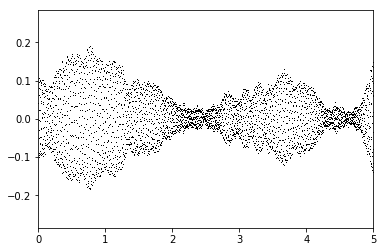

In [14]:
plt.plot(ts/86400., rvs, 'k,')
plt.xlim([0.,5.]);

Ramp-up period

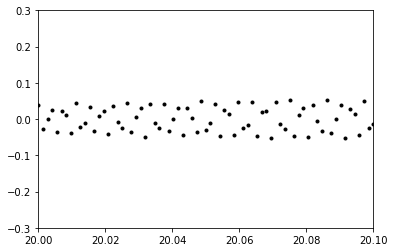

In [20]:
plt.plot(ts/86400., rvs, 'k.')
plt.xlim([20.,20.1])
plt.ylim([-0.3,0.3]);

Looks coherent over short timescales.

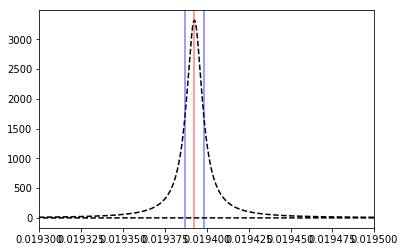

In [12]:
powers = np.fft.fft(rvs)
real_powers = (powers * powers.conj()).real
omegas = np.fft.fftfreq(rvs.shape[-1]) / dt * 2. * np.pi
plt.plot(omegas, real_powers, 'k--')
plt.xlim([0.0193,0.0195])
plt.axvline(omega, alpha=0.5, c='r')
plt.axvline(omega-gamma, alpha=0.5, c='b')
plt.axvline(omega+gamma, alpha=0.5, c='b');

Tests: turning off driving and/or damping makes the FT very clean.

Now do this for many modes (drawing from the envelope of modes & amplitudes in Chaplin paper) & co-add all RVs